In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import arviz as az

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install gxx`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.


# Importing the data

In [1]:
data = pd.read_csv("HistoricalData_MSFT.csv")
data.set_index("Date", inplace=True)
close_last_col = [ float(val.replace("$", "")) for val in data["Close/Last"] ]
data["Close/Last"] = close_last_col
data

NameError: name 'pd' is not defined

In [ ]:
data.dtypes

Close/Last    float64
Volume          int64
Open           object
High           object
Low            object
dtype: object

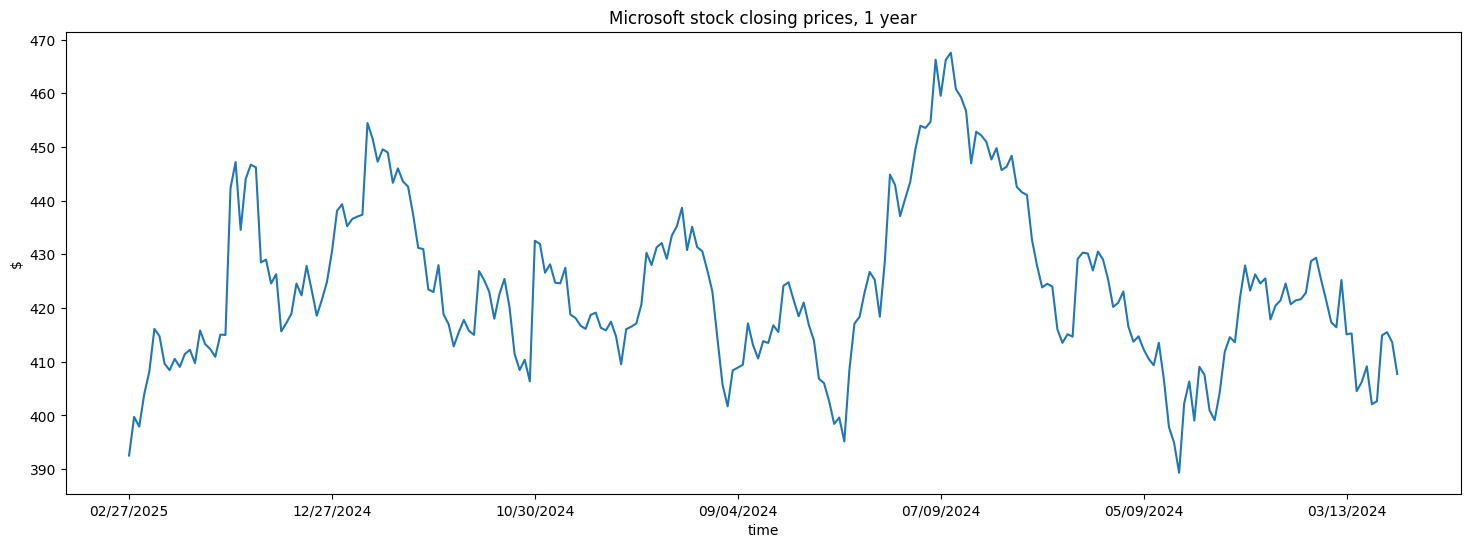

In [ ]:
plt.figure(figsize = (18,6))
plt.plot(data["Close/Last"])
plt.title("Microsoft stock closing prices, 1 year")
plt.xticks(np.arange(0,len(data),40))
#plt.savefig("microsoft_stock_1year.pdf", bbox_inches="tight")
plt.show()

In [ ]:
# daily log-return data
y = data["Close/Last"].copy()
len_y = len(y)
y_log_return = np.zeros((len_y-1))
for i in range(1,len_y):
    if i < len_y-1:
        y_log_return[i] = np.log( y[i] / y[i-1] )

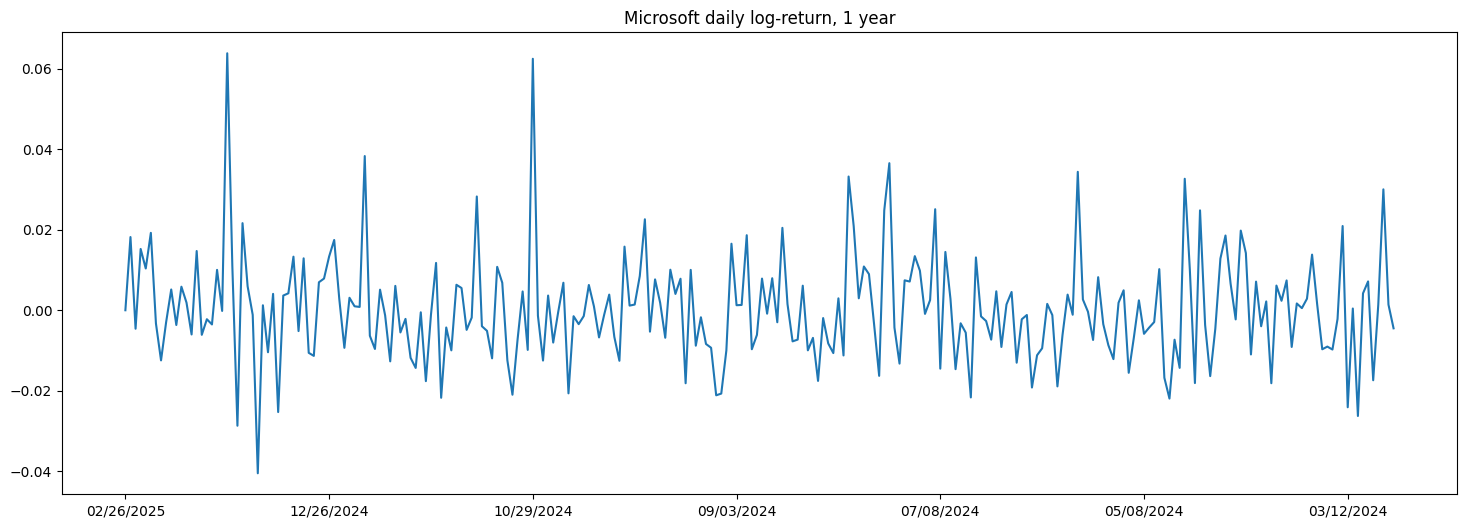

In [ ]:
# plotting the daily log return data
dates = data.index[1:len_y]
plt.figure(figsize = (18,6))
plt.plot(dates, y_log_return)
plt.title("Microsoft daily log-return, 1 year")
plt.xticks(np.arange(0,len(data)-1,40))
plt.show()

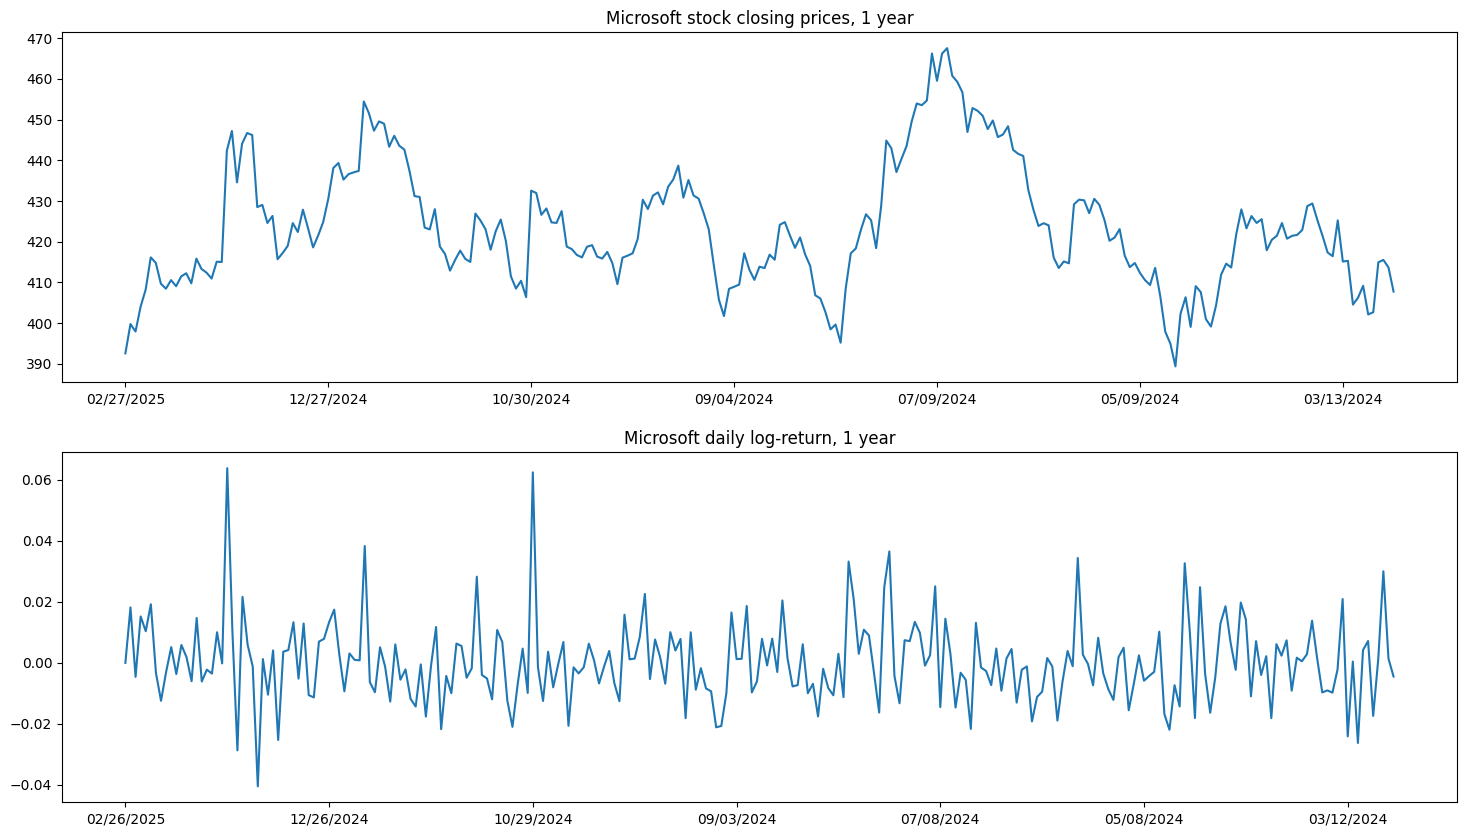

In [ ]:
fig, ax = plt.subplots(2,1, figsize = (18,10))
ax[0].plot(data["Close/Last"])
ax[0].set_title("Microsoft stock closing prices, 1 year")
ax[0].set_xticks(np.arange(0,len(data)-1,40))
ax[1].plot(dates, y_log_return)
ax[1].set_title("Microsoft daily log-return, 1 year")
ax[1].set_xticks(np.arange(0,len(data)-1,40))
plt.savefig("Microsoft_stock_price_and_log_return.pdf", bbox_inches="tight")
plt.show()

## PyMC

In [ ]:
with pm.Model() as model:
    # priors
    mu = pm.Normal("$\mu$", mu=0, sigma=3)
    sigma = pm.HalfNormal("$\sigma$", sigma=5)
    # likelihood
    Y = pm.Normal("Y", mu=(mu - sigma**2/2), sigma = sigma, observed=y_log_return)
    # posterior
    trace = pm.sample(1000, cores=2)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [$\mu$, $\sigma$]


C:\Users\ktkvil18\AppData\Local\Programs\Python\Python310\lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 79 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


<Figure size 700x700 with 0 Axes>

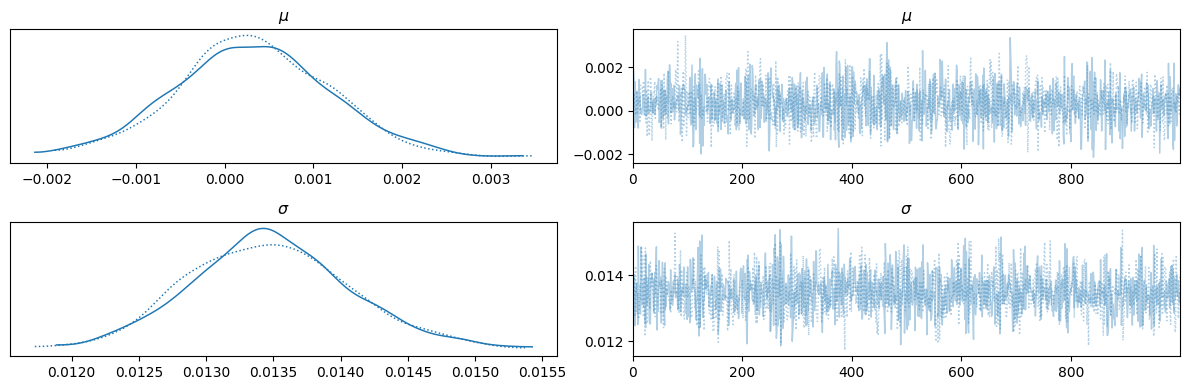

In [ ]:
plt.figure(figsize=(7,7))
pm.plot_trace(trace)
plt.tight_layout()
plt.savefig("traces_spe_sp.pdf", bbox_inches="tight")
plt.tight_layout()

In [ ]:
mu_trace = trace.posterior.variables['$\\mu$'][0]
sigma_trace = trace.posterior.variables['$\\sigma$'][0]

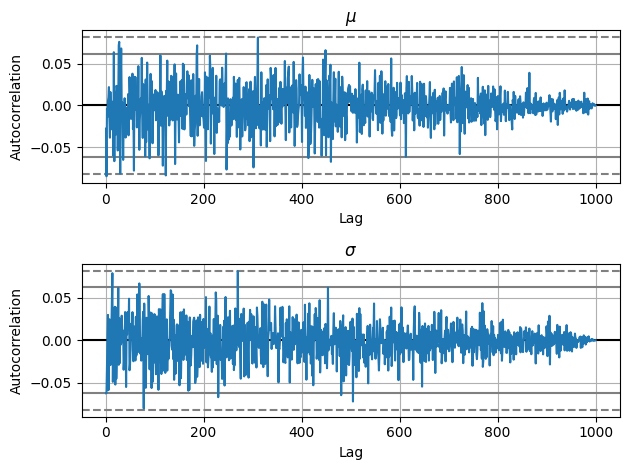

In [ ]:
fig, ax = plt.subplots(2,1)
pd.plotting.autocorrelation_plot(mu_trace, ax=ax[0])
pd.plotting.autocorrelation_plot(sigma_trace, ax=ax[1])
ax[0].set_title("$\mu$")
ax[1].set_title("$\sigma$")
plt.tight_layout()
plt.savefig("Autocorrelation_plots.pdf", bbox_inches="tight")
plt.show()

In [ ]:
print("ESS of mu: " + str(az.ess(np.array(mu_trace))))
print("ESS of sigma: " + str(az.ess(np.array(sigma_trace))))

ESS of mu: 1062.9150654515158
ESS of sigma: 1135.6237420049372


In [ ]:
mean_mu = np.mean(np.array(mu_trace))
mean_sigma = np.mean(np.array(sigma_trace))

print("Mean of mu: " + str(mean_mu))
print("Mean of sigma: " + str(mean_sigma))

Mean of mu: 0.00030975193997097864
Mean of sigma: 0.013489149209568318


In [ ]:
print(np.exp(mean_mu)-1)
print(np.exp(mean_sigma))

0.00030979991805679674
1.0135805382405305
